## Finite Horizon Nonlinear Control Algorithms
Overall, our problem, in discrete time, can be written as 
\begin{align*}
	\min_{\substack{u_0, \ldots, u_{\tau -1} \\ z_0, \ldots, z_\tau  } }  & \sum_{t=0}^{\tau-1}h_t(z_t) + g_t(u_t)  + h_\tau(z_\tau) 
	\\
	\text{subject to} \quad &  z_{t+1} = \phi_t(z_t, u_t)  \quad  \text{for} \  t \in \{0, \ldots \tau-1\} \\
	& z_0 = \bar z_0.
\end{align*} 
where $h_t, g_t$ are some costs on the state and control variables and $\phi_t$ are the discrete-time dynamics obtained after discretizing the continuous time dynamics. 

In the following, we simply present a regularized Gauss-Newton algorithm and a regularized differential dynamic programming approach. 
The ideal approach for such dynamical problems is dynamic programming, detailed below.


In [23]:
import torch
import time
import math
import os
import numpy as np
import pandas as pd
torch.set_default_dtype(torch.float64)

$\renewcommand{\state}{z} \renewcommand{\ctrl}{u} \renewcommand{\horizon}{\tau} \renewcommand{\cost}{h} \renewcommand{\finalcost}{h_{\tau}} \renewcommand{\dyn}{\phi} \renewcommand{\costogo}{c} \renewcommand{\auxstate}{y}$
<a id='dyn_prog'></a>

### Dynamic Programming
Consider a generic dynamical problem of the form:

\begin{align}
	\min_{\substack{\ctrl_0, \ldots, \ctrl_{\horizon -1}  \\ \state_0, \ldots, \state_\horizon  } }  & \sum_{t=0}^{\horizon-1}\cost_t(\state_t, \ctrl_t)  + \finalcost(\state_\horizon) \nonumber
	\\
	\text{subject to} \quad &  \state_{t+1} = \dyn_t(\state_t, \ctrl_t)  \quad  \text{for} \  t \in \{0, \ldots \horizon-1\} \nonumber \\
	& \state_0 = \bar \state_0. \nonumber
\end{align} 

The idea of dynamic programming is to decompose dynamical problems as the one above into a sequence of nested sub-problems. Namely, we define the cost-to-go from $ \state_t$ at time $t \in \{0, \ldots, \horizon-1\}$ as 
\begin{align}
	\costogo_t( \state_t) = \min_{\substack{\ctrl_t,\ldots, \ctrl_{\horizon-1}\\\auxstate_t,\ldots, \auxstate_\horizon}} \quad & \sum_{s=t}^{\horizon-1} \cost_{s}(\auxstate_{s}, \ctrl_{s}) + \cost_\horizon(\auxstate_\horizon) \nonumber
	\\
	\text{subject to} \quad & \auxstate_{s+1} =  \dyn_{s}(\auxstate_{s}, \ctrl_{s}) \quad \text{for} \ s \in \{t, \ldots, \horizon-1\}, \nonumber \\
	& \auxstate_{t} =  \state_{t}. \nonumber
\end{align}
The cost-to-go from $\state_\horizon$ at time $\horizon$ is simply the last cost, namely,
\begin{equation}
  \costogo_\horizon(\state_\horizon) = \cost_\horizon(\state_\horizon),
\end{equation}
and the original problem  amounts to compute $\costogo_0(\bar \state_0)$.
The cost-to-go functions define nested sub-problems that are linked for $t\in \{0, \ldots, \horizon-1\}$ by the Bellman equation
\begin{equation}
	\costogo_{t}( \state_t) = \min_{\ctrl_t }  \left\{ \cost_t(\state_t, \ctrl_t) + \costogo_{t+1}(\dyn_t( \state_t, \ctrl_t))\right\}.
\end{equation}
The optimal control variables are naturally derived from the resolution of the Bellman equations. Namely, if one knows the cost-to-go at time $t+1$ from any state, the optimal control at time $t$ from state $\state_t$ is given by  the policy
\begin{equation}
\pi_t^*( \state_t) = \arg\min_{\ctrl_t } \left\{ \cost_t(\state_t, \ctrl_t) + \costogo_{t+1}(\dyn_t( \state_t, \ctrl_t))\right\}.
\end{equation}
Denoting the procedure that back-propagates the cost-to-go functions as
$$
\textrm{BP}:
	\dyn, \cost, \costogo_{t+1} \rightarrow \left(\begin{array}{c}
		\costogo_{t}: \state\rightarrow	\min_{\ctrl }  \left\{ \cost(\state, \ctrl) + \costogo_{t+1}(\dyn( \state, \ctrl))\right\},\\
		\pi_t^* :\state \rightarrow	 \arg\min_{\ctrl} \left\{ \cost(\state, \ctrl) + \costogo_{t+1}(\dyn( \state, \ctrl))\right\}
	\end{array}\right),
$$
this suggests the following approach.

1. **Backward pass** Compute recursively the cost-to-go functions $\costogo_t$ for $t=\horizon, \ldots, 0$ using the Bellman starting from $\costogo_\horizon$ given by the final cost. Record at each step the optimal policy function $\pi_t^*$. Namely, compute from $\costogo_\horizon= \cost_\horizon$, recording at each step $\pi_t^*$,

$$
\costogo_t, \pi^*_t = \textrm{BP}(\dyn_t, \cost_t, \costogo_{t+1}) \quad \text{for} \ t \in \{\horizon-1, \ldots, 0\}
$$
    
	
2. **Roll-out phase** Unroll the optimal trajectory that starts from time 0 at $\bar \state_0$, follows the dynamics $\dyn_t$, and use at each step the optimal control given by the optimal policy function. Namely, starting from $\state_0^* = \bar \state_0$, compute

$$
\ctrl^*_t= \pi_t^*(\state_t^*), \qquad \state_{t+1}= \dyn_t(\state_t^*, \ctrl^*_t) \qquad \text{for $t=0, \ldots, \horizon-1$.}
$$

The output sequence of control $\ctrl_0^*, \ldots, \ctrl_{\horizon-1}^*$ is then the optimal sequence of control and the trajectory $\state_0^*, \ldots, \state_\horizon^*$ is the optimal trajectory for the problem. 
The bottleneck of the approach is the ability to solve the Bellman equation, i.e.,  having access to the procedure $\textrm{Bell}$ defined above. For most problems, this procedure cannot be computed in closed form. One exception is the case of linear dynamics and quadratic costs. The algorithms presented below use this fact to compute an optimal sequence of controllers iteratively. 

$\renewcommand{\diffctrl}{v} \renewcommand{\diffstate}{y} \renewcommand{\lin}{\ell} \renewcommand{\costogo}{c} \renewcommand{\Bell}{\textrm{Bell}} \newcommand{\qua}{q}$
<a id='gauss_newton'></a>

### Gauss-Newton
Although our original  problem is written as a constrained problem, it can be seen just as a problem over the control variables. Namely, define the function $f$ that, given an initial state $z_0$ and a sequence of controls $u = (u_0, \ldots, u_{\tau-1})$ output the trajectory $f(u) = (f_0(u), f_1(u), \ldots, f_\tau(u))= (z_0, z_1,\ldots, z_\tau)$ defined as

$$	f_{t+1}(u)  = \phi_t(f_t(u),u_t), \quad \text{for} \ t \in\{0, \ldots, \tau-1\}$$
with $f_0(u) = z_0$. 


Our problem can then be written as
$$
\min_u h(f(u)) + g(u)
$$
where $h(z) = \sum_{t=0}^{\tau} h(z_t)$ for $z = (z_0, \ldots, z_\tau)$ and $g(u) = \sum_{t=0}^{\tau-1} g_t(u_t)$ for $u = (u_0, \ldots, u_{\tau-1})$.

A regularized Gauss-Newton step consists of minimizing a linear-quadratic model of the problem with an additional regularization term. Namely, a regularized Gauss-Newton step consists of iterating steps of the form

\begin{align}
u^{\textrm{new}} & = u + \diffctrl^\gamma  \\
\text{where} \quad \diffctrl^\gamma & = \arg\min_{\diffctrl} q_h^{f(u)}(\ell_f^u(\diffctrl)) + q_g^u(u) + \frac{1}{2\gamma} \|\diffctrl\|_2^2 \tag{GN} 
\end{align}
where for a function $f$, we denote 
$$
\ell_f^x(y) =\nabla f(x)^\top y, \qquad 
q_f^x(y)  = \nabla f(x)^\top y +\frac{1}{2} \nabla^2 f(x)[y, y, \cdot], $$
respectively the linear and quadratic approximations of $f$ such that e.g. $f(x+y) \approx  f(x) + \ell_f^x(y)$ and 
 $\gamma$ acts a step-size: the smaller the gamma, the smaller the $\diffctrl^\gamma$.

The problem (GN) is a linear quadratic control problem that can be solved exactly by dynamic programming as presented before. Overall, one regularized Gauss-Newton step amounts to the following steps.

1. A **forward pass** that records the derivatives of the dynamics and the costs to express  the problem (GN) in terms of the quadratic approximations of the costs $h_t, g_t$ and the linear approximations of the dynamics $\phi_t$.

2. A **backward pass** that computes the optimal policies of the linear-quadratic problem using the fact that the operator $\textrm{BP}$ can be formulated analytically for linear dynamics and quadratic costs. Namely, the policies are computed as
$$
\costogo_t^\gamma, \pi_t^\gamma = \textrm{BPLQ}_{\gamma}(\lin_{\dyn_t}^{\state_t, \ctrl_t}, \qua_{\cost_t}^{\state_t, \ctrl_t}, \costogo_{t+1}^\gamma) \quad \text{for} \ t = \horizon-1, \ldots, 0,
$$
where $\textrm{BPLQ}_{\gamma}$ solves the Bellman equation for linear dynamics and quadratic costs with an additional regularization defined by $\gamma$, and $\state_t$ are the states corresponding to the current sequence of controls $\ctrl_t$.

3. A **roll-out phase** that computes the solution of the linear-quadratic problem by using the optimal policies computed in the backward pass and apply them step by step on the linearized trajectories, namely the sequence $\diffctrl^\gamma$ is computed as 

$$
		\diffctrl_t^\gamma= \pi_t^\gamma(\diffstate_t), \qquad \diffstate_{t+1} = \lin_{\dyn_t}^{\state_t, \ctrl_t}(\state_t + \diffstate_t, \ctrl_t + \diffctrl^\gamma_t) \qquad \text{for $t=0, \ldots, \horizon-1$},
$$

Each step depends on the choice of the step size $\gamma$ defined above. This step-size is chosen such that 

$$ h(f(u+ \diffctrl^\gamma)) + g(u+ \diffctrl^\gamma)  \leq h(f(u)) + g(u) + q_h^{f(u)}(\ell_f^u(\diffctrl^\gamma)) + q_g^u(\diffctrl^\gamma) + \frac{1}{2\gamma} \|\diffctrl^\gamma\|_2^2, $$

by decreasing the step size until this criterion is satisfied. The computed step size is kept in memory for the next step. The next sequence of controllers is then $u_{new} = u + \diffctrl^\gamma$.

The computational scheme of a Gauss-Newton step is illustrated below, the $f_t$ here correspond to the $\phi_t$ above.

<center><img src="fig/ilqr_gn.png" alt="Computational Scheme of a Gauss-Newton Oracle" width="900" /></center>


<a id='ddp'></a>


### Differential Dynamic Programming 

The differential dynamic programming approach is very similar to a Gauss-Newton step except that, rather than computing the roll-out phase using the linear approximations of the dynamics, the roll-out phase uses the exact trajectories. The algorithm can be summarized as follows:

1. A **forward pass** that records the derivatives of the dynamics and the costs to express  the problem (GN) in terms of the quadratic approximations of the costs $h_t, g_t$ and the linear approximations of the dynamics $\phi_t$.

2. A **backward pass** that computes the optimal policies of the linear-quadratic problem using the fact that the operator $\textrm{Bell}$ can be formulated analytically for linear dynamics and quadratic costs. Namely, the policies are computed as

$$
\costogo_t^\gamma, \pi_t^\gamma = \mathrm{LQBP}_{\gamma}(\lin_{\dyn_t}^{\state_t, \ctrl_t}, q_{\cost_t}^{\state_t, \ctrl_t}, \costogo_{t+1}^\gamma) \quad \text{for} \ t = \horizon-1, \ldots, 0.
$$

3. A **roll-out phase** that computes the solution of the linear-quadratic problem by using the optimal policies computed in the backward pass and apply them step by step on the exact trajectories, namely the sequence $\delta u^\gamma$ is computed as 

$$
		\diffctrl_t^\gamma= \pi_t^\gamma( \diffstate_t), \qquad \diffstate_{t+1} =  \dyn_t(\state_t + \diffstate_t, \ctrl_t + \diffctrl_t^\gamma ) - \dyn_t(\state_t, \ctrl_t) \qquad \text{for $t=0, \ldots, \horizon-1$}
$$

We use the same line-search as for Gauss-Newton to find the step-size


<a id='implementation'></a>


## Implementation

The implementation of these algorithms require to store the derivatives with respect to the dynamics and the costs at each step of the algorithm. In that purpose, we define a generic class as follows. Note that the class implmented in the toolbox can also store quadratic approximations of the dynamics to implement Newton steps or a differential dynamic programming approach with quadratic approximations. See the technical report [Roulet et al 2022]((#refs) for a complete mathematical exposition of these algorithms. 


In [2]:
import torch
import time
from typing import Callable, List

from torch.autograd import grad as auto_grad
from envs.torch_utils import auto_multi_grad


class DiffEnv:
    def __init__(self):
        super(DiffEnv, self).__init__()
        self.dim_ctrl, self.dim_state = None, None
        self.dt, self.horizon = None, None
        self.state, self.time_iter = None, 0
        self.init_state, self.init_time_iter = None, None
        self.viewer = None

    def discrete_dyn(self, state: torch.Tensor, ctrl: torch.Tensor, time_iter: int) -> torch.Tensor:
        raise NotImplementedError

    def costs(self, next_state: torch.Tensor, ctrl: torch.Tensor, time_iter: int) -> (torch.Tensor, torch.Tensor):
        return torch.tensor(0.), torch.tensor(0.)

    def step(self, ctrl: torch.Tensor, approx: str = None) -> (torch.Tensor, torch.Tensor):
        if approx == 'linquad':
            next_state = diff_discrete_dyn(self.discrete_dyn, self.state, ctrl, self.time_iter)
            new_time_iter = self.time_iter + 1
            cost = diff_cost(self.costs, next_state, ctrl, new_time_iter)
        else:
            next_state = self.discrete_dyn(self.state, ctrl, self.time_iter)
            new_time_iter = self.time_iter + 1
            cost = sum(self.costs(next_state, ctrl, new_time_iter))
        self.state, self.time_iter = next_state, new_time_iter
        return next_state, cost

    def forward(self, cmd: torch.Tensor, approx: str = None, reset: bool = True) \
            -> (List[torch.Tensor], List[torch.Tensor]):
        if reset:
            self.reset(requires_grad=approx is not None)
        dim_state, dim_ctrl, horizon = self.dim_state, self.dim_ctrl, cmd.shape[0]
        state = self.state
        traj = [state]
        init_cost = torch.tensor(0.)
        init_cost.hess_state, init_cost.grad_state = torch.zeros(dim_state, dim_state), torch.zeros(dim_state)
        costs = [init_cost]
        for t in range(horizon):
            state, cost = self.step(cmd[t], approx=approx)
            traj.append(state)
            costs.append(cost)
        return traj, costs

    def reset(self, requires_grad=False) -> torch.Tensor:
        self.time_iter = self.init_time_iter
        self.state = self.init_state
        self.state.requires_grad = requires_grad
        return self.state

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

    def visualize(self, cmd: torch.Tensor, dt: float =None):
        if dt is None:
            dt = self.dt
        self.reset()
        for ctrl in cmd:
            self.render()
            time.sleep(dt)
            self.step(ctrl)
        self.render()
        self.close()


def diff_discrete_dyn(discrete_dyn: Callable, state: torch.Tensor,
                      ctrl: torch.Tensor, time_iter: int) -> torch.Tensor:
    next_state = discrete_dyn(state, ctrl, time_iter)

    grad_dyn_state = auto_multi_grad(next_state, state)
    grad_dyn_ctrl = auto_multi_grad(next_state, ctrl)
    for attr, val in zip(['grad_dyn_state', 'grad_dyn_ctrl'], [grad_dyn_state, grad_dyn_ctrl]):
        val = val.data if val is not None else None
        setattr(next_state, attr, val)
    return next_state


def diff_cost(costs: Callable, next_state: torch.Tensor, ctrl: torch.Tensor, time_iter: int) -> torch.Tensor:
    dim_state, dim_ctrl = next_state.shape[0], ctrl.shape[0]

    cost_next_state, cost_ctrl = costs(next_state, ctrl, time_iter)
    cost = cost_next_state + cost_ctrl

    if cost_next_state.grad_fn is not None:
        cost_grad_state = auto_grad(cost_next_state, next_state, create_graph=True)[0]
        cost.hess_state = auto_multi_grad(cost_grad_state, next_state).data
        cost.grad_state = cost_grad_state.data
        cost.has_cost_state = True
    else:
        cost.hess_state, cost.grad_state = torch.zeros(dim_state, dim_state), torch.zeros(dim_state)
        cost.has_cost_state = False

    if cost_ctrl.grad_fn is not None:
        cost_grad_ctrl = auto_grad(cost_ctrl, ctrl, create_graph=True)[0]
        cost.hess_ctrl = auto_multi_grad(cost_grad_ctrl, ctrl).data
        cost.grad_ctrl = cost_grad_ctrl.data
    else:
        cost.hess_ctrl, cost.grad_ctrl = torch.zeros(dim_ctrl, dim_ctrl), torch.zeros(dim_ctrl)

    return cost


We can then instantiate  our previous model of a car within the above class to be able to access the linear approximations of the dynamics and the quadratic approximations of the cost.  

In [3]:
import colorsys
import math

import numpy as np
import torch
import os
import pandas as pd
from matplotlib import pyplot as plt

from envs.discretization import euler, runge_kutta4, runge_kutta4_cst_ctrl
from envs import rendering
from envs.tracks.tracks import get_track
from envs.torch_utils import smooth_relu
from envs.car import set_window_viewer, add_car_to_viewer, add_track_to_viewer, plot_track, plot_traj



class Car(DiffEnv):
    def __init__(self, dt=0.02, discretization='rk4_cst_ctrl', horizon=20,
                 track='simple', model='simple',
                 reg_ctrl=1e-6, reg_cont=0.1, reg_lag=10., reg_speed=0.1, reg_bar=100., reg_obs=0.,
                 cost='contouring', time_penalty='vref_squared',
                 vref=3., vinit=1., constrain_angle=math.pi/3, acc_bounds=(-0.1, 1.), seed=0
                 ):
        super(Car, self).__init__()
        if seed != 0:
            torch.manual_seed(seed)
            vinit = vinit + 1e-2*torch.randn(1).item()
            reg_cont, reg_lag, reg_speed = reg_cont + 1e-3 * torch.randn(1).item(), \
                                           reg_lag + 1e-3 * torch.randn(1).item(), \
                                           reg_speed + 1e-3 * torch.randn(1).item()

        # dyn parameters
        self.dt, self.discretization, self.horizon = dt, discretization, horizon
        self.model = model
        self.vref, self.constrain_angle, self.acc_bounds = vref, constrain_angle, acc_bounds

        # cost parameters
        self.reg_ctrl, self.reg_cont, self.reg_lag, self.reg_speed, self.reg_bar, self.reg_obs = \
            reg_ctrl, reg_cont, reg_lag, reg_speed, reg_bar, reg_obs
        self.cost_type, self.time_penalty = cost, time_penalty

        # track parameters
        self.track, self.inner_track, self.outer_track = get_track(track)
        dx_ref, dy_ref = self.track.derivative(torch.tensor(0.))
        phi_ref = torch.atan2(dy_ref, dx_ref)

        if model == 'simple':
            self.init_state = torch.tensor([0., 0., phi_ref, vinit, 0., vinit])
            self.dim_ctrl, self.dim_state = 3, 6
        elif model == 'real':
            self.init_state = torch.tensor([0., 0., phi_ref, vinit, 0., 0., 0., vinit])
            self.dim_ctrl, self.dim_state = 3, 8
        else:
            raise NotImplementedError

        if self.discretization == 'RK4':
            self.dim_ctrl *= 3

        self.dyn_csts = pd.read_json(os.path.join('envs/bicycle_model.json'), typ='series')

        self.cartrans = None
        self.init_time_iter = 0

        time_obstacle = max(self.track._t) / 20
        self.obstacle = self.track.evaluate(time_obstacle) + torch.tensor([0.2, 0.])

    def discrete_dyn(self, state, ctrl, time_iter):
        if self.model == 'real':
            dyn = self.bicycle_model
        elif self.model == 'simple':
            dyn = self.simple_model
        else:
            raise NotImplementedError
        if self.discretization == 'euler':
            next_state = euler(dyn, state, ctrl, self.dt)
        elif self.discretization == 'rk4':
            next_state = runge_kutta4(dyn, state, ctrl, self.dt)
        elif self.discretization == 'rk4_cst_ctrl':
            next_state = runge_kutta4_cst_ctrl(dyn, state, ctrl, self.dt)
        else:
            raise NotImplementedError
        return next_state

    def simple_model(self, state, ctrl):
        x, y, phi, v, tref, vtref = state
        a, delta, atref = ctrl
        delta = 2/math.pi*torch.arctan(delta)*self.constrain_angle
        carlength = 1.5*self.dyn_csts['car_l']

        dx = v * torch.cos(phi)
        dy = v * torch.sin(phi)
        dv = a
        dphi = v * torch.tan(delta)/carlength
        dtref = vtref
        dvtref = atref
        return torch.stack([dx, dy, dphi, dv, dtref, dvtref])

    def bicycle_model(self, state, ctrl):
        x, y, phi, vx, vy, vphi, tref, vtref = state
        a, delta, atref = ctrl
        delta = 2/math.pi*torch.arctan(delta)*self.constrain_angle
        # hardcode constraints on the acceleration
        gap = self.acc_bounds[1] - self.acc_bounds[0]
        a = gap*torch.sigmoid(4 * a / gap) + self.acc_bounds[0]


        Cm1, Cm2, Cr0, Cr2,\
        Br, Cr, Dr, Bf, Cf, Df,\
        m, Iz, lf, lr = [self.dyn_csts[key] for key in ['Cm1', 'Cm2', 'Cr0', 'Cr2',
                                                        'Br', 'Cr', 'Dr', 'Bf', 'Cf', 'Df',
                                                        'm', 'Iz', 'lf', 'lr']]
        alphaf = delta - torch.atan2(vphi*lf + vy, vx)
        alphar = torch.atan2(vphi*lr - vy, vx)
        Fry = Dr*torch.sin(Cr*torch.atan(Br*alphar))
        Ffy = Df*torch.sin(Cf*torch.atan(Bf*alphaf))
        Frx = (Cm1 - Cm2*vx)*a - Cr0 - Cr2*vx**2
        dx = torch.cos(phi)*vx - torch.sin(phi)*vy
        dy = torch.sin(phi)*vx + torch.cos(phi)*vy
        dphi = vphi
        dvx = (Frx - Ffy*torch.sin(delta) + m*vy*vphi)/m
        dvy = (Fry + Ffy*torch.cos(delta) - m*vx*vphi)/m
        dvphi = (Ffy*lf*torch.cos(delta) - Fry*lr)/Iz
        dtref = vtref
        dvtref = atref
        return torch.stack([dx, dy, dphi, dvx, dvy, dvphi, dtref, dvtref])

    def costs(self, next_state, ctrl, time_iter):
        if self.model == 'simple':
            x, y, phi, v, tref, vtref = next_state
        else:
            x, y, phi, vx, vy, vphi, tref, vtref = next_state

        if self.cost_type == 'contouring':
            qC, qL, qVs = self.reg_cont, self.reg_lag, self.reg_speed
            x_ref, y_ref = self.track.evaluate(tref)
            dx_ref, dy_ref = self.track.derivative(tref)
            phi_ref = torch.atan2(dy_ref, dx_ref)

            cont_err = torch.sin(phi_ref)*(x-x_ref) - torch.cos(phi_ref)*(y-y_ref)
            lag_err = -torch.cos(phi_ref)*(x-x_ref) - torch.sin(phi_ref)*(y-y_ref)
            cost_next_state = qC*cont_err**2 + qL*lag_err**2
            if self.time_penalty == 'tref':
                cost_next_state = cost_next_state - qVs*tref
            elif self.time_penalty == 'dref':
                cost_next_state = cost_next_state - qVs*vtref*self.dt
            elif self.time_penalty == 'dref_squared':
                cost_next_state = cost_next_state - qVs*vtref*self.dt*tref
            elif self.time_penalty == 'vref_squared':
                cost_next_state = cost_next_state + qVs*(vtref-self.vref)**2*self.dt**2
            else:
                raise NotImplementedError
        elif self.cost_type == 'exact':
            time = torch.tensor(time_iter*self.vref*self.dt)
            x_ref, y_ref = self.track.evaluate(time)
            cost_next_state = (x - x_ref)**2 + (y - y_ref)**2
        else:
            raise NotImplementedError

        if type(self.reg_ctrl) == tuple:
            if self.discretization in ['euler', 'RK4_cst_ctrl']:
                a, delta, atref = ctrl
                cost_ctrl = self.reg_ctrl[0]*(a**2 + delta**2) + self.reg_ctrl[1]*atref**2
            elif self.discretization == 'RK4':
                accs, deltas, atrefs = ctrl[::3], ctrl[1::3], ctrl[2::3]
                cost_ctrl = self.reg_ctrl[0]*((accs**2).sum() + (deltas**2).sum()) \
                            + self.reg_ctrl[1]*(atrefs**2).sum()
            else:
                raise NotImplementedError
        else:
            cost_ctrl = self.reg_ctrl*ctrl.dot(ctrl)

        barr_next_state = self.barrier(next_state)
        cost_next_state = cost_next_state + barr_next_state

        return cost_next_state, cost_ctrl

    def barrier(self, next_state):
        barr_next_state = -1e-6*torch.log(next_state[-1])

        carwidth = 1.5*self.dyn_csts['car_w']

        tref = next_state[-2]
        x, y = next_state[:2]
        point = torch.tensor([x, y])
        for i, border in enumerate([self.inner_track, self.outer_track]):
            border_point = border.evaluate(tref)
            dpos = border.derivative(tref)
            v = torch.sqrt(torch.sum(dpos**2))
            normal = torch.tensor([dpos[1], -dpos[0]])/v
            if i == 0:
                # inner
                barr_next_state = barr_next_state \
                                  + self.reg_bar * smooth_relu(carwidth / 2 - (point - border_point).dot(normal)) ** 2
            else:
                # outer
                barr_next_state = barr_next_state \
                                  + self.reg_bar * smooth_relu((point - border_point).dot(normal) + carwidth / 2) ** 2
        barr_next_state = barr_next_state

        if self.reg_obs > 0.:
            barr_next_state = barr_next_state \
                              + self.reg_obs * smooth_relu(carwidth ** 2 - torch.sum((point - self.obstacle) ** 2))

        return barr_next_state

    def set_viewer(self):
        nb_points = 500
        carlength, carwidth = 1.5 * self.dyn_csts['car_l'], 1.5 * self.dyn_csts['car_w']

        time = torch.linspace(0, max(self.track._t), nb_points)
        track_points = self.outer_track.evaluate(time).numpy()
        min_x, max_x = min(track_points[:, 0]), max(track_points[:, 0])
        min_y, max_y = min(track_points[:, 1]), max(track_points[:, 1])

        self.viewer = set_window_viewer(min_x, max_x, min_y, max_y, 2*carlength)
        add_track_to_viewer(self.viewer, self.track, self.inner_track, self.outer_track)

        self.cartrans = add_car_to_viewer(self.viewer, carlength, carwidth)

    def plot_track(self, fig=None, ax=None):
        fig, ax = plot_track(self.track, self.inner_track, self.outer_track, fig=fig, ax=ax)
        return fig, ax

    def plot_traj(self, traj, fig, ax, add_colorbar=True):
        return plot_traj(traj, fig, ax, model=self.model, add_colorbar=add_colorbar)

    def render(self, title=None):
        if self.viewer is None:
            self.set_viewer()
        self.cartrans.set_translation(self.state[0].item(), self.state[1].item())
        self.cartrans.set_rotation(self.state[2].item())
        return self.viewer.render(title=title)



2024-08-01 16:05:31.291 Python[59775:1688755] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/pf/znths45963l2918jylv3wzjr0134jq/T/org.python.python.savedState


In the following code, we compute the trajectory associated to a sequence of controls and display the intermediate approximations.

In [4]:
car = Car(model='simple', track='simple')
horizon = 20

accs = torch.linspace(0, 2, horizon) # Linearly increasing acceleration
deltas = math.pi/6*torch.ones(horizon) # Constant steering angle
accsrefs = accs
cmd = torch.stack((accs, deltas, accsrefs), dim=1) # Sequence of controls
cmd.requires_grad = True

traj, costs = car.forward(cmd, approx='linquad')

state = traj[5]
print('Gradients of the dynamics at time step 5:\n {0}\n{1}'.format(state.grad_dyn_state, state.grad_dyn_ctrl))
cost = costs[5]
print('Quadratic approximation of the state cost at time step 5:\n {0}\n{1}'.format(cost.hess_state, cost.grad_state))


Gradients of the dynamics at time step 5:
 tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0067,  0.0192,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0186,  0.0073,  0.0740,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0200,  1.0000]])
tensor([[ 1.8629e-04,  7.2784e-05,  7.4028e-04,  2.0000e-02,  0.0000e+00,
          0.0000e+00],
        [-4.5463e-04,  1.2556e-03,  1.3135e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0000e-04,
          2.0000e-02]])
Quadratic approximation of the state cost at time step 5:
 tensor([[ 2.0000e+01,  1.9347e-06,  0.0000e+00,  0.0000e+00, -2.0000e+01,
          0.0000e+00],
        [ 1.9347e-06,  2.0000e-01,  0.0000e+00,  0.0000e+00, -2.5639e-06,
          0.0000e+00],
        [ 0.0000e+00,  0.00

Given the linear approximations of the dynamics and the quadratic approximations of the costs, we can perform a backward pass that computes the policies. These policies are affine, i.e., of the form

$$ \pi_t(z_t) = K_t z_t + k_t,$$

where $K_t$ is called the *gain* and $k_t$ is called the *offset*. The cost-to-go functions are quadratic of the form

$$ c_t(x) = \frac{1}{2} x^\top J_t x + j_t^\top x + j_{t, 0}. $$

We use $J_t, j_t$ and $j_t$ to parameterize these functions. See e.g. [[Roulet et al, 2022]](#refs) for the mathematical derivations. 

Finally, the Bellman equation seeks for a minimum in the control variable. Hence, if the sub-problem defining the Bellman equation is not convex we cannot ensure that we have found a minimum. Rather than checking if the sub-problem is convex we simply check whether the rest is negative or not. A negative rest ensures a good descent direction.

In [10]:
def lin_quad_backward(traj, costs, reg_ctrl=1., handle_bad_dir='flag'):
    # Compute iteratively the cost-to-go and the policies by going backward in time
    horizon = len(traj)-1
    
    # The first cost-to-go function is defined by the quadratic approximation of the last state
    J, j, jcst = costs[-1].hess_state, costs[-1].grad_state, 0.
    feasible = True
    
    # The policies are stored in a list of gains
    gains = list()
    for t in range(horizon-1, -1, -1):
        P, p = costs[t].hess_state, costs[t].grad_state
        Q, q = costs[t+1].hess_ctrl, costs[t+1].grad_ctrl
        A, B = traj[t+1].grad_dyn_state.t(), traj[t+1].grad_dyn_ctrl.t()

        J, j, jcst, K, k, feasible = bell_step(J, j, jcst, P, p, Q, q, A, B, reg_ctrl, handle_bad_dir)
        gain = dict(gain_ctrl=K, offset_ctrl=k)
        gains.insert(0, gain)
        if not feasible:
            break
    return gains, jcst, feasible

def bell_step(J, j, jcst, P, p, Q, q, A, B, reg, handle_bad_dir='flag'):
    # Check if the step is good or not by looking at the sign of the rest of the minimization
    # If the rest is positive, the subproblem was necessirally not convex and we did not properly solve the Bellman equation
    # A rigorous approach would check at if step if the matrix H below was semi-definite positive
    # We rather simply check the rest which avoids computing an svd at each step
    H = Q + B.t().mm(J.mm(B)) + reg * torch.eye(Q.shape[0])

    next_J, next_j, rest, K, k = bell_core(J, j, H, P, p, q, A, B)
    if rest > 0:
        if handle_bad_dir == 'flag':
            next_J = next_j = next_jcst = K = k = None
            feasible = False
        elif handle_bad_dir == 'modify_hess':
            (lam, U) = torch.eig(H, eigenvectors=True)
            lam = torch.abs(lam[:, 0])
            H = torch.mm(U, torch.mm(torch.diag(lam), U.t()))
            next_J, next_j, rest, K, k = bell_core(J, j, H, P, p, q, A, B)
            feasible = True
            assert rest < 0
            next_jcst = jcst + rest
        elif handle_bad_dir == 'let_it_be':
            feasible = True
            next_jcst = jcst + rest
        else:
            raise NotImplementedError
    else:
        feasible = True
        next_jcst = jcst + rest
    return next_J, next_j, next_jcst, K, k, feasible


def bell_core(J, j, H, P, p, q, A, B):
    # Core algebra manipulations
    K = - torch.linalg.solve(H, B.t().mm(J.mm(A)))
    k = - torch.linalg.solve(H, q + B.t().mv(j))
    next_J = P + A.t().mm(J.mm(A) + J.mm(B.mm(K)))
    next_j = p + A.t().mv(j + J.mv(B.mv(k)))
    rest = 0.5 * (q + B.t().mv(j)).dot(k)
    return next_J, next_j, rest, K, k

Once the policies have been computed in the form of gains, we can find the next sequence of controllers by either rolling out the policies along the linearized trajectories or along the exact trajectories as coded below.

In [11]:
def roll_out_lin(traj, gains):
    dim_state, horizon = traj[0].shape, len(traj)-1
    dim_ctrl = gains[0]['offset_ctrl'].shape[0]

    diff_x = torch.zeros(dim_state)
    diff_cmd = torch.zeros(horizon, dim_ctrl)

    for t in range(horizon):
        A = traj[t + 1].grad_dyn_state.t()
        B = traj[t + 1].grad_dyn_ctrl.t() 
        diff_ctrl = gains[t]['gain_ctrl'].mv(diff_x) + gains[t]['offset_ctrl']
        diff_cmd[t] = diff_ctrl
        diff_x = A.mv(diff_x) + B.mv(diff_ctrl)
    return diff_cmd


def roll_out_exact(env, traj, gains, cmd):
    dim_state, horizon = traj[0].shape, len(traj) - 1
    diff_x, state = torch.zeros(dim_state), env.init_state
    diff_cmd = torch.zeros_like(cmd) 
    diff_cmd.requires_grad = state.requires_grad = False

    for t in range(horizon):
        diff_ctrl = gains[t]['gain_ctrl'].mv(diff_x) + gains[t]['offset_ctrl']
        diff_cmd[t] = diff_ctrl
        state = env.discrete_dyn(state, cmd[t].data + diff_ctrl, t)
        diff_x = state - traj[t+1].data
    return diff_cmd

We have now implemented the forward pass, the backward pass, and the roll-out phase. Regularized Gauss-Newton and Differential Dynamic Programming methods can then readily be implemented. We define the oracles associated with each algorithm and wrap them in a backtracking line search.

In [12]:
def gn_reg_oracle(env, traj, costs, cmd, handle_bad_dir):
    def oracle(stepsize):
        gains, opt_step, feasible = lin_quad_backward(traj, costs, 1 / stepsize, handle_bad_dir=handle_bad_dir)
        out = (roll_out_lin(traj, gains), opt_step) if feasible else (None, None)
        return out
    return oracle

def ddp_reg_oracle(env, traj, costs, cmd, handle_bad_dir):
    def oracle(stepsize):
        gains, opt_step, feasible = lin_quad_backward(traj, costs, 1 / stepsize, handle_bad_dir=handle_bad_dir)
        out = (roll_out_exact(env, traj, gains, cmd), opt_step) if feasible else (None, None)
        return out
    return oracle

oracles = dict(classic_linquad_reg=gn_reg_oracle, ddp_linquad_reg=ddp_reg_oracle)

def min_step(env, traj, costs, cmd, stepsize,
             line_search, algo, handle_bad_dir):
    def func(cmd):
        traj, costs = env.forward(cmd)
        cost = sum(costs)
        return cost
    
    oracle = oracles[algo](env, traj, costs, cmd, handle_bad_dir)
    if line_search:
        diff_cmd, stepsize = backtrack_line_search(func, cmd, oracle, stepsize)
    else:
        diff_cmd, _ = oracle(stepsize)
    if diff_cmd is not None:
        next_cmd = cmd + diff_cmd
        traj, costs = env.forward(next_cmd, approx='linquad')
    else:
        next_cmd = traj = costs = None
    return next_cmd, traj, costs, stepsize

def backtrack_line_search(func, var, oracle, stepsize):
    decrease_fac = 0.1
    increase_fac = 10.
    stepsize *= increase_fac
    dir = float(np.sign(stepsize))

    curr_val = func(var)
    diff_var, dec_obj = oracle(stepsize)

    if diff_var is None:
        decrease = False
        stop = np.abs(stepsize) < 1e-32
    else:
        new_val = func(var + diff_var)
        decrease = dir * (new_val - (curr_val + dec_obj)) < 0
        stop = torch.norm(diff_var) < 1e-12

    while not decrease and not stop:
        stepsize *= decrease_fac

        diff_var, dec_obj = oracle(stepsize)

        if diff_var is None:
            decrease = False
            stop = np.abs(stepsize) < 1e-32
        else:
            new_val = func(var + diff_var)
            decrease = dir * (new_val - (curr_val + dec_obj)) < 0
            stop = torch.norm(diff_var) < 1e-12

    if stop:
        print('line-search failed')
    return diff_var, stepsize


We finally define a function that iterates one of the above algorithms.

In [13]:
from algorithms.run_min_algo import check_cvg_status
from utils_pipeline.optim_helpers import print_info_step

def run_min_algo(env, max_iter=10, algo='ddp_linquad_reg', stepsize=1., line_search=True, handle_bad_dir='flag'):
    cmd = torch.zeros(env.horizon, env.dim_ctrl)
    cmd.requires_grad = True
    
    traj, costs = env.forward(cmd, approx='linquad')
    metrics, iteration, time_start = None, 0, 0.
    metrics = collect_info(metrics, env, cmd, costs, iteration, stepsize, algo, time_start)
    status = check_cvg_status(metrics)

    while status == 'running' and iteration < max_iter:
        start_time = time.time()
        cmd, traj, costs, stepsize = min_step(env, traj, costs, cmd, stepsize,
                                              line_search, algo, handle_bad_dir)
        iteration += 1
        time_iter = time.time() - start_time
        metrics = collect_info(metrics, env, cmd, costs, iteration, stepsize, algo, time_iter)
        stop = check_cvg_status(metrics)

    return cmd.data, metrics

def collect_info(metrics, env, cmd, costs, iteration, stepsize, algo, time_iter):
    cumul_time = 0. if iteration == 0 else metrics['time'][-1]
    cost = sum(costs) if costs is not None else torch.tensor(float('nan'))
    info_step = dict(iteration=iteration, time=cumul_time + time_iter, cost=cost.item(), stepsize=stepsize, algo=algo)
    format_types = ['int', 'time', 'scientific', 'scientific', 'string']
    print_info_step(info_step, format_types, iteration == 0)
    if metrics is None:
        metrics = {key: [info_step[key]] for key in info_step.keys()}
    else:
        for key in info_step.keys():
            metrics[key].append(info_step[key])
    return metrics

We can now test our algorithms and compare their convergence.

Run with classic_linquad_reg
iteration           time                cost                stepsize            algo                
0                   0:00:00             1.12e-01            1.00e+00            classic_linquad_reg 
1                   0:00:00.699290      6.97e-02            1.00e+01            classic_linquad_reg 
2                   0:00:01.324002      6.44e-02            1.00e+02            classic_linquad_reg 
3                   0:00:01.988331      6.27e-02            1.00e+02            classic_linquad_reg 
4                   0:00:02.654109      6.14e-02            1.00e+02            classic_linquad_reg 
5                   0:00:03.254764      5.40e-02            1.00e+03            classic_linquad_reg 
6                   0:00:03.920956      5.04e-02            1.00e+02            classic_linquad_reg 
7                   0:00:04.522613      4.40e-02            1.00e+03            classic_linquad_reg 
8                   0:00:05.131332      3.66e-02            1.

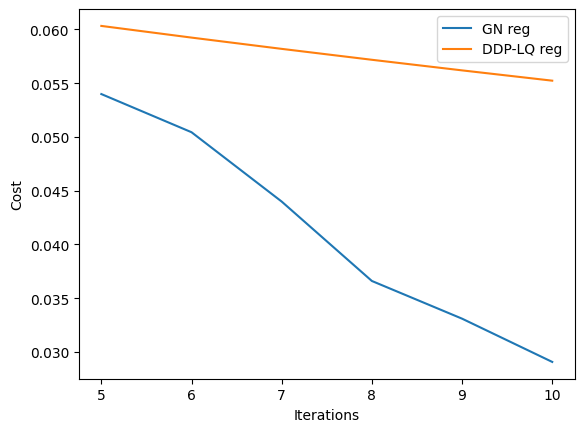

In [16]:
from matplotlib import pyplot as plt
from finite_horizon_control.utils_plot import plot_conv_costs

horizon = 40

# Try with simple or real models
env = Car(model='simple', track='simple', horizon=horizon,
          reg_cont=1., reg_lag=10., reg_speed=1., reg_bar=100., vref=3.)
algos = ['classic_linquad_reg', 'ddp_linquad_reg']

metrics_algos = pd.DataFrame()
cmd_opts = list()
for algo in algos:
    print('Run with {}'.format(algo))
    cmd_opt, metrics = run_min_algo(env, max_iter=10, algo=algo)
    cmd_opts.append(cmd_opt)
    metrics_algos = pd.concat([metrics_algos, pd.DataFrame(metrics)], ignore_index=True)

plot_conv_costs(metrics_algos, start_plot_after=5)
plt.show()


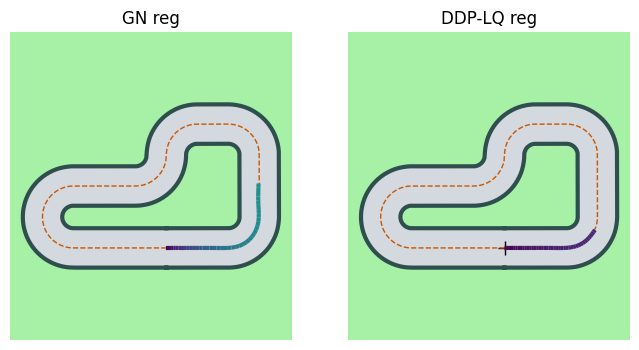

In [17]:
from finite_horizon_control.utils_plot import get_nice_writing

nice_writing = get_nice_writing()

# Observe the trajectories 
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

for i, cmd in enumerate(cmd_opts):
    fig, ax = env.plot_track(fig, axs[i])
    traj, _ = env.forward(cmd)
    fig = env.plot_traj(traj, fig, ax, add_colorbar=False)
    ax.title.set_text(nice_writing[algos[i]])

In [18]:
# Visualize the movements 
for i, cmd in enumerate(cmd_opts):
    env.reset()
    env.render(title=nice_writing[algos[i]])
    for ctrl in cmd:
        time.sleep(env.dt)
        env.step(ctrl)
        env.render(title=nice_writing[algos[i]])
    time.sleep(car.dt)
env.viewer.close()

FALLBACK (log once): Fallback to SW vertex for line stipple
FALLBACK (log once): Fallback to SW vertex processing, m_disable_code: 2000
FALLBACK (log once): Fallback to SW vertex processing in drawCore, m_disable_code: 2000


For short horizons (e.g. 40 time steps), we observe that the algorithms converge fast, yet the horizon is too small for the car to travel the whole track. For longer horizons, the problem gets more difficult as shown in the following code. To observe the trajectories after different maximum number of iterations, we wrap our code in a pipeline that regularly saves the results, see the source code for more details on the pipeline. 

env_cfg:{'env': 'simple_car', 'track': 'simple', 'reg_cont': 0.1, 'reg_lag': 10.0, 'reg_speed': 1.0, 'reg_bar': 100.0, 'vref': 3.0}
optim_cfg:{'max_iter': 100, 'algo': 'classic_linquad_reg'}
env_cfg:{'env': 'simple_car', 'track': 'simple', 'reg_cont': 0.1, 'reg_lag': 10.0, 'reg_speed': 1.0, 'reg_bar': 100.0, 'vref': 3.0}
optim_cfg:{'max_iter': 100, 'algo': 'ddp_linquad_reg'}
env_cfg:{'env': 'simple_car', 'track': 'simple', 'reg_cont': 0.1, 'reg_lag': 10.0, 'reg_speed': 1.0, 'reg_bar': 100.0, 'vref': 3.0}
optim_cfg:{'max_iter': 30, 'algo': 'ddp_linquad_reg'}
17                  0:00:15.510475      4.89e-03            1.56e-07            9.11e+01            ddp_linquad_reg     
18                  0:00:15.987693      4.89e-03            9.38e-08            1.25e-04            ddp_linquad_reg     
19                  0:00:16.260207      4.89e-03            8.11e-08            6.00e-04            ddp_linquad_reg     
20                  0:00:16.730512      4.89e-03            5.15e-08     

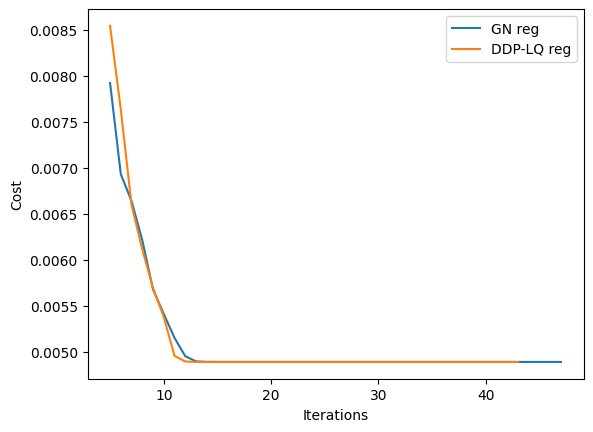

In [20]:
from matplotlib import pyplot as plt
from finite_horizon_control.fhc_pipeline import solve_ctrl_pb_incrementally

env_cfg = dict(env='simple_car', track='simple',
               reg_cont=0.1, reg_lag=10., reg_speed=1., reg_bar=100., vref=3.
               )
optim_cfg = dict(max_iter=100)

algos = ['classic_linquad_reg','ddp_linquad_reg']

metrics_algos = pd.DataFrame()
cmd_opts = list()
for algo in algos:
    optim_cfg.update(algo=algo)
    exp_outputs = solve_ctrl_pb_incrementally(env_cfg, optim_cfg)
    cmd_opts.append(exp_outputs['cmd_opt'])
    metrics = exp_outputs['metrics']
    metrics_algos = pd.concat([metrics_algos, pd.DataFrame(metrics)], ignore_index=True)
    
plot_conv_costs(metrics_algos, start_plot_after=5)
plt.show()

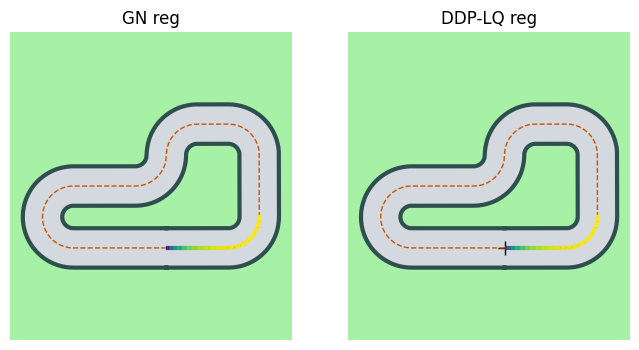

In [21]:
from envs.choose_env import make_env

env = make_env(env_cfg)
# Observe the trajectories 
fig, axs = plt.subplots(ncols=2, figsize=(8, 4))

for i, cmd in enumerate(cmd_opts):
    fig, ax = env.plot_track(fig, axs[i])
    traj, _ = env.forward(cmd)
    fig = env.plot_traj(traj, fig, ax, add_colorbar=False)
    ax.title.set_text(nice_writing[algos[i]])

In [22]:
# Visualize the movements 
for i, cmd in enumerate(cmd_opts):
    env.reset()
    env.render(title=nice_writing[algos[i]])
    for ctrl in cmd:
        time.sleep(env.dt)
        env.step(ctrl)
        env.render(title=nice_writing[algos[i]])
    time.sleep(car.dt)
env.viewer.close()

For long horizons, the algorithms can be very slow. On the other hand, we need long horizons to ensure that the car makes a whole loop on the track. To trade-off these constraints with consider a Model Predictive Control approach presented in the notebook [Model Predictive Control](mpc.ipynb).

### Additional Details
The code presented in this notebook is almost identical to the one provided in the folder src. The main difference is that we implemented the oracles for both the risk neutral case (i.e., the case presented above) and the risk sensitive case where an additional noise parameter is to be optimized. The objective consists then in a min-max problem which minimizes with respect to the control variables and maximizes with respect to the noise variables. Hence noises variables are added in the formulation of the environments and the oracles.

<a id='refs'></a>
## References

**Iterative Linear Quadratic Optimization for Nonlinear Control: Differentiable Programming Algorithmic Templates.**  
Vincent Roulet, Siddharta Srinivasa, Maryam Fazel, Zaid Harchaoui.  
*Technical Report*

**Iterative Linearized Control: Stable Algorithms and Complexity Guarantees.**  
Vincent Roulet, Siddharta Srinivasa, Dmitry Drusvyatskiy, Zaid Harchaoui.  
*Proceedings of the 36th International Conference on Machine Learning (ICML 2019).*  